# Tutorial 2 - Qiskit and Quantum Teleportation
a) Some quick qiskit practice.
b) Implementing Quantum teleportation.

In [8]:
# This notebook was last updated 15 Feb 2025 by Joseph Lee
# Status - Complete

## Before starting...

Make sure you've openned the Lecture 7 notebook and made all the proper installations! Here, we will start getting some practice with circuit design!

## Setup
**The setup I will be using is:**
- Python 3.12.8
- Qiskit 1.3.1
- qiskit_aer 0.15.1
- Numpy 2.2.1

In [4]:
import qiskit
qiskit.__version__

'1.4.0'

In [5]:
import numpy as np
np.__version__

'1.26.4'

In [6]:
import qiskit_aer
qiskit_aer.__version__

'0.16.1'

In [7]:
# Preamble
import qiskit
qiskit.__version__
from qiskit import *

from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

import numpy as np
from math import pi

%matplotlib inline

from IPython.display import Image ## For displaying Images

print("Imports complete.")

Imports complete.


# Quantum Teleportation Circuit


Recall that the circuit for teleportation is:

<img src="TeleportationCircuit.png" width="750">

We will defer all the math to the lecture 7 slide. But as a quick recap:
- Alice wants to teleport a qubit to Bob. We start by preparing the state $|\psi\rangle$ Alice wants to teleport and preparing a Bell state to be shared between Alice and Bob.
- Alice then encodes the state $|\psi\rangle$ onto her half of the Bell pair.
- Then, she measures her state, leading to four possible outcomes.
- Depending on the outcome, she calls Bob and tells him how to fix his state.

# Qiskit implementation

In [33]:
#For Bell State 1/sqrt(2)(|01>-|10>)
def quantum_teleportation_simulated(theta = 0.0, phi = 0.0, lamb = 0.0):
# Step 1: First, create the necessary classical and quantum registries and initialize the circuit.
    qubits = QuantumRegister(3, "Qubits")
    crz = ClassicalRegister(1, name='crz')        
    crx = ClassicalRegister(1, name='crx')         
    crb = ClassicalRegister(1, name='crb')
    qc = QuantumCircuit(qubits, crz, crx, crb)

# Now that the circuit is ready, we can start building!
# Implement the first part of the circuit - creating the teleporting state and the Bell Pair between Alice and Bob.

    #Set up state to teleport
    qc.u(theta, phi, lamb, 0)
    qc.x(1)
    qc.h(1)
    qc.cx(1,2)
    qc.x(2)
    # Apply a barrier after each key step to separate the steps out!

    qc.barrier()
    # Be sure to run qc.draw() or qc.draw('mpl') after every cell to check that the circuit is working.
    # Step 2: Encode the teleporting state onto Alice's half of the Bell Pair.
    qc.cx(0, 1)
    qc.h(0)
    qc.barrier()

    # Apply a barrier and draw the circuit.
    qc.measure(0, crz[0])             
    qc.measure(1, crx[0])           
    qc.barrier()
    # Bob then applies gates to his bits based on the results of Alice's outcome

    # if first bit is one, apply X gate
    with qc.if_test((crx, 0)):
        qc.x(2)

    # if zero bit is one, apply Z gate
    with qc.if_test((crz, 0)):
        qc.z(2)

    qc.barrier()

    # We now measure Bob's qubit to make sure we did this correctly.
    qc.measure(2, crb[0])

    # When we read this plot, we should look only at the last qubit (the bottom most number)

    # run with classical simulator
    result = AerSimulator().run(qc).result()
    # collect stats
    statistics = result.get_counts()
    # plot
    display(plot_histogram(statistics)) 

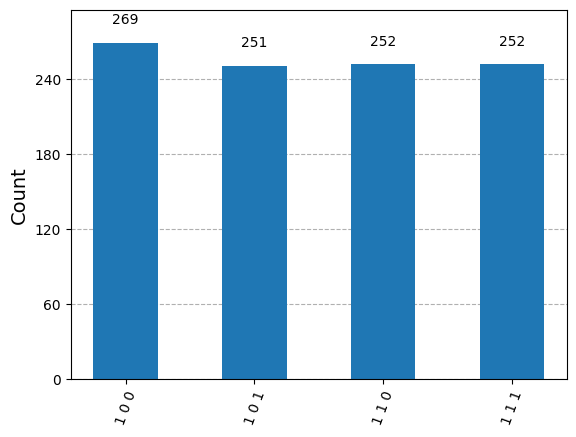

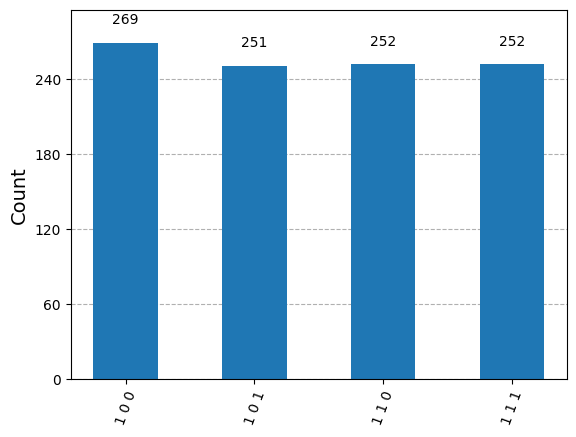

In [34]:
#Let's test three different beginning states

#|1> - we expect 1 being the only measured state for qubit 2
quantum_teleportation_simulated(theta = pi, phi = 0.0, lamb = 0.0)


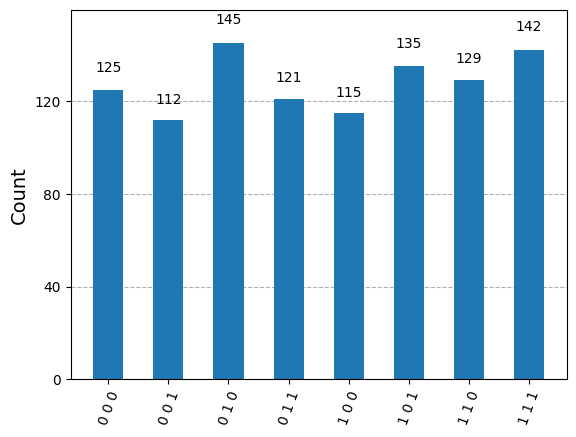

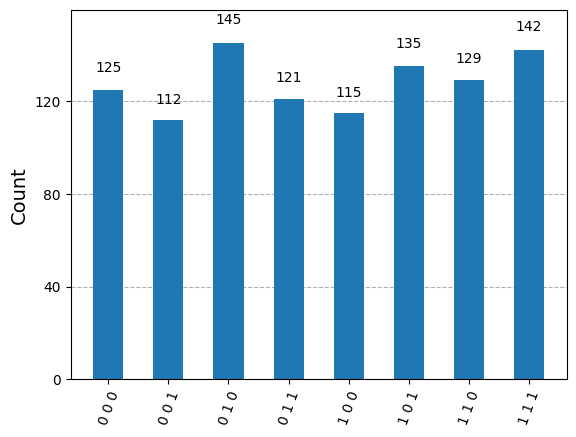

In [35]:
 
#1/sqrt(2) (|0>+|1>) - we expect a uniform distribution of measured states

quantum_teleportation_simulated(theta = pi/2, phi = 0.0, lamb = 0.0)



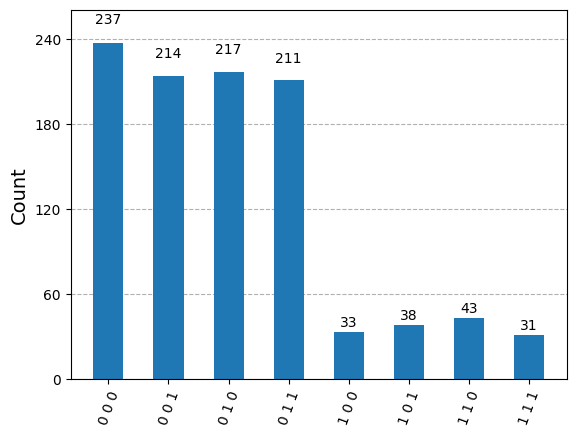

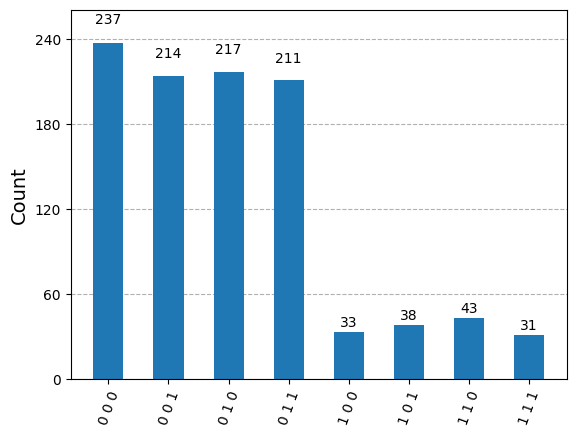

In [36]:
#cos(pi/8)|0> + sin(pi/8)|1> - we expect 85 percent of measured states to have 0 in the second qubit
# and 15 percent having 1 as the second qubit
quantum_teleportation_simulated(theta = pi/4, phi = 0.0, lamb = 0.0)

In [44]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [41]:
service = QiskitRuntimeService(token='e1816d36734769cead0ac8774d406072977fe419aad0d46927507d83a3f2741bd766526b436a3aada0b45242d3a0e7757a789b59ee123d27814f55d3a83c3b6c',channel='ibm_quantum')
backend = service.least_busy(simulator = False, operational = True)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

In [49]:
#For Bell State 1/sqrt(2)(|01>-|10>)
def quantum_teleportation(theta = 0.0, phi = 0.0, lamb = 0.0):
# Step 1: First, create the necessary classical and quantum registries and initialize the circuit.
    qubits = QuantumRegister(3, "Qubits")
    crz = ClassicalRegister(1, name='crz')        
    crx = ClassicalRegister(1, name='crx')         
    crb = ClassicalRegister(1, name='crb')
    qc = QuantumCircuit(qubits, crz, crx, crb)

# Now that the circuit is ready, we can start building!
# Implement the first part of the circuit - creating the teleporting state and the Bell Pair between Alice and Bob.

    #Set up state to teleport
    qc.u(theta, phi, lamb, 0)
    qc.x(1)
    qc.h(1)
    qc.cx(1,2)
    qc.x(2)
    # Apply a barrier after each key step to separate the steps out!

    qc.barrier()
    # Be sure to run qc.draw() or qc.draw('mpl') after every cell to check that the circuit is working.
    # Step 2: Encode the teleporting state onto Alice's half of the Bell Pair.
    qc.cx(0, 1)
    qc.h(0)
    qc.barrier()

    # Apply a barrier and draw the circuit.
    qc.measure(0, crz[0])             
    qc.measure(1, crx[0])           
    qc.barrier()
    # Bob then applies gates to his bits based on the results of Alice's outcome

    # if first bit is one, apply X gate
    with qc.if_test((crx, 0)):
        qc.x(2)

    # if zero bit is one, apply Z gate
    with qc.if_test((crz, 0)):
        qc.z(2)

    qc.barrier()

    # We now measure Bob's qubit to make sure we did this correctly.
    qc.measure(2, crb[0])

    # When we read this plot, we should look only at the last qubit (the bottom most number)

    # run with classical simulator
    sampler = Sampler(backend)
    transpiled_circuit = pm.run(qc)
    # collect stats
    job = sampler.run([transpiled_circuit])
    return job
    

In [50]:
job = quantum_teleportation(theta = pi, phi = 0.0, lamb = 0.0)


{'1': 3852, '0': 244}


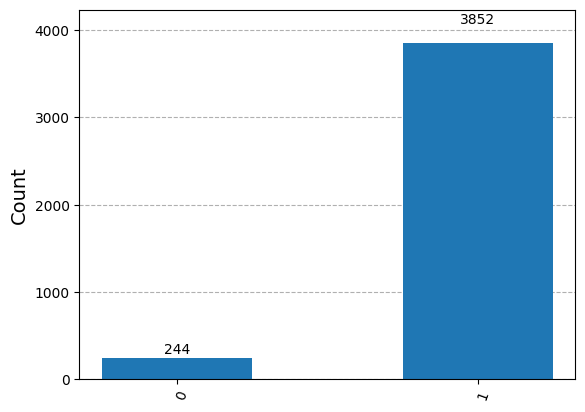

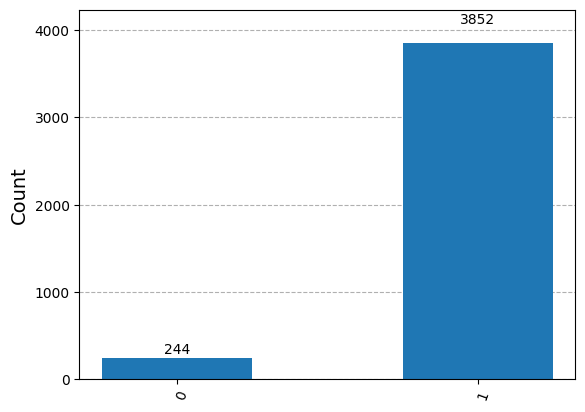

In [61]:
#Expect 100 percent ket 1s
statistics =job.result()[0].data.crb.get_counts()
    # plot
display(plot_histogram(statistics)) 

In our simulation we got 100 percent of our results in ket 1 when we applied the U(pi, 0,0) gate to our qubit we wanted to teleport. On an actual quantum computer we get 96.3 percent ket 1. Given there's less than a 4 percent error, we can chalk this up to the instability of actual qubits on super conducting machines from enviromental noise. Let's see how it does on the other two states we tested with the simulator.

In [62]:
job2 = quantum_teleportation(theta = pi/2, phi = 0.0, lamb = 0.0)

In [63]:
job3 = quantum_teleportation(theta = pi/4, phi = 0.0, lamb = 0.0)

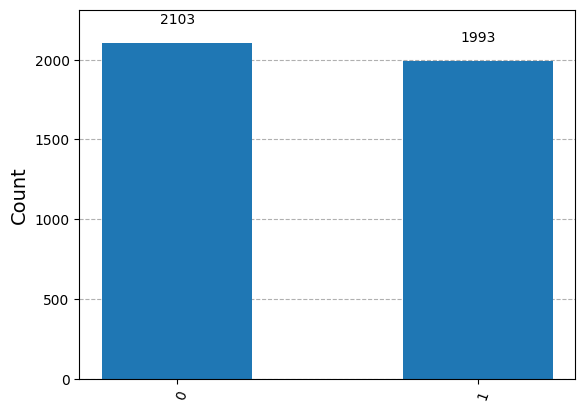

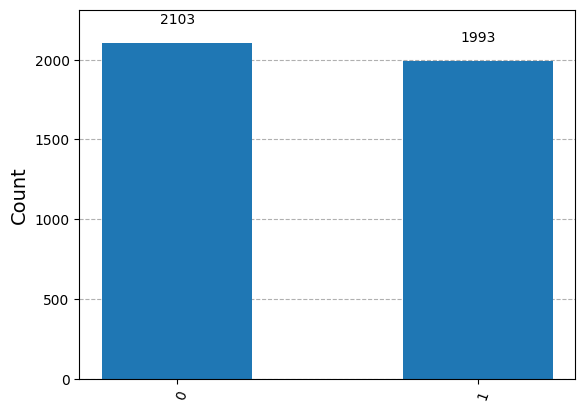

In [64]:
#Expect 100 percent ket 1s
statistics =job2.result()[0].data.crb.get_counts()
    # plot
display(plot_histogram(statistics)) 

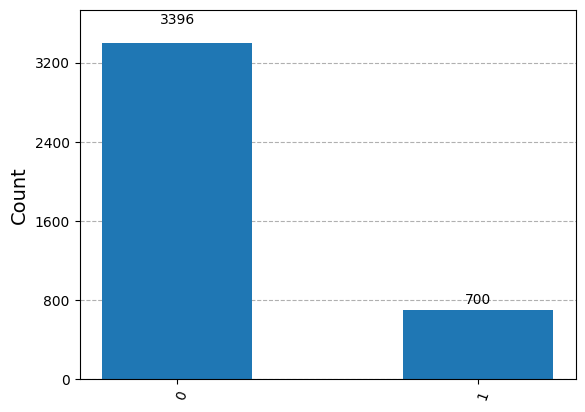

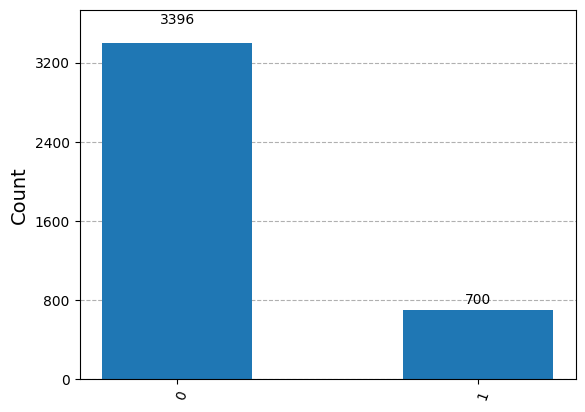

In [65]:
#Expect 100 percent ket 1s
statistics =job3.result()[0].data.crb.get_counts()
    # plot
display(plot_histogram(statistics)) 

Once again our results are very close to what wed expect, with the 1/sqrt(2)(|0>+|1>) state resulting in 52% |0> and 48% |1> and with the cos(pi/8)|0>+sin(pi/8)|1> state we get an error of less than one percent with 84.9% chance of measuring |0> and 15.1% chance of measuring a |1>. These are remarkably accurate with error rates smaller than the |1> attempt.

In [66]:
! pip3 install pyzmq


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip


In [21]:
from qiskit.visualization import plot_bloch_vector
from qiskit_aer import Aer

qc = QuantumCircuit(1)
qc.h(0)
backend = Aer.get_backend('statevector_simulator')
statevector = backend.run(qc).result().get_statevector()
sv = [statevector[0],statevector[1]]
#plot_bloch_vector(sv, title="New Bloch Sphere")